In [ ]:
%pylab inline --no-import-all

#import numpy as np
#import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# constants
hbar = 1
m = 1
w = 1   # Trap frequency
g = 0

L_unit = np.sqrt(hbar/m/w)

# Units?
length = 10 * L_unit
delta_x = 0.1/2 * L_unit

L = 2*length
N = int(np.ceil(L / delta_x))
dx = L / N

#x = np.arange(-length, length, dx)
#N = len(x)

x = np.arange(N) * dx - L/2

cooling_phase = 1.0 + 0j

# borrowing this from the iscimath seminar:
D1_forward = (np.diag(np.ones(N - 1), k=1) - np.diag(np.ones(N))) / dx
D1_backward = -D1_forward.T
D1 = (D1_forward + D1_backward) / 2
D2 = D1_forward @ D1_backward

# Add periodic boundary conditions
D1[0][N-1] = D1[N-1][0] = D1[0][1]
D2[0][N-1] = D2[N-1][0] = D2[0][1]

def generate_constants(_delta_x = 0.1):
    # constants
    hbar = 1
    m = 1
    w = 1   # Trap frequency
    g = 0

    L_unit = np.sqrt(hbar/m/w)

    # Units?
    length = 10 * L_unit
    delta_x = _delta_x/2 * L_unit

    L = 2*length
    N = int(np.ceil(L / delta_x))
    dx = L / N

    #x = np.arange(-length, length, dx)
    #N = len(x)

    x = np.arange(N) * dx - L/2

    cooling_phase = 1.0 + 0j

    # borrowing this from the iscimath seminar:
    D1_forward = (np.diag(np.ones(N - 1), k=1) - np.diag(np.ones(N))) / dx
    D1_backward = -D1_forward.T
    D1 = (D1_forward + D1_backward) / 2
    D2 = D1_forward @ D1_backward

    # Add periodic boundary conditions
    D1[0][N-1] = D1[N-1][0] = D1[0][1]
    D2[0][N-1] = D2[N-1][0] = D2[0][1]
    return N

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def gaussian(x, x0, variance=1.0):
    """
    calculates a gaussian (variance = sigma^2)
    I'm really not sure what to use for the initial profile
    """
    return np.exp((-(x - x0)**2) / 2.0 / variance)


def _noise(seed):
    """ generate uniform density but with randomized phases """
    rng = np.random.default_rng(seed)
    angles = rng.random(N) * 2 * np.pi
    return np.exp(1.j * angles)


def fourier_noise(n_modes=4, dirichlet=True, seed=3):
    """ Generates random sinuosodal noise independent of box size """

    np.random.seed(seed)
    n = np.arange(n_modes) - n_modes // 2

    # ks = 2*np.pi * np.fft.fftfreq(N, dx)
    # ks[inds] = 2*np.pi * n /L
    # np.where(...)

    # create list of wavenumbers for the modes to generate
    ks = 2 * np.pi * n / L

    # create random amplitudes for each mode (-0.5, 0.5)
    As = (np.random.random(n_modes) - 0.5) * 2

    # random phases too
    phases = np.random.random(n_modes) * 2 * np.pi

    # box space
    _x = (1 + np.arange(N)) * dx

    if dirichlet:
        # for dirichlet, the end points are zero (as each mode is guaranteed to fit in the box, as phase=0)
        # although: there is no complex phase here, so: will this generate turbulance as the phase is uniform?
        psi = sum(_A * (np.exp(1j * _k * _x) - np.cos(_k * _x))
                  for _A, _k in zip(As, ks))
    else:
        # basically do a fourier series but of these specific modes, i.e. sum up each sine wave
        # the ends may not be zero here
        psi = sum(_A * np.exp(1j * (_k * _x + _phase))
                  for _A, _k, _phase in zip(As, ks, phases))

    return psi


def calc_diff(psi, i, order):
    """ calculates the first and second diff """
    if order == 1:
        return (psi[i + 1] - psi[i - 1]) / 2.0 / dx
    if order == 2:
        return (psi[i + 1] - 2 * psi[i] + psi[i - 1]) / dx**2
    return 0


#Check np.gradient?


def V(x):
    return 0
    """ just gonna have a harmonic potential """
    #return m * w**2 * x**2 / 2



def compute_dpsi_dt(t, psi):
    """Return dpsi/dt for the GPE."""
    phase = 1 / (1j * hbar * cooling_phase / np.abs(cooling_phase))
    n = abs(psi)**2
    return phase * (-hbar / 2 / m * (D2 @ psi) + (V(x) + g * n) * psi)

def get_angle(angle):
    """Return a continuous angle."""
    for i in range(1, len(angle)):
        angle0 = angle[i - 1] - np.pi
        angle[i] = (angle[i] - angle0) % (2 * np.pi) + angle0
    return angle


# peek at the final psi(x)
#plt.plot(psis[-1])
#plt.plot(get_angle(np.angle(psis[-1])))

In [ ]:
!pip install mmfutils

     |████████████████████████████████| 230 kB 5.2 MB/s 
     |████████████████████████████████| 251 kB 49.5 MB/s 
  Created wheel for mmfutils: filename=mmfutils-0.5.4-cp37-cp37m-linux_x86_64.whl size=400603 sha256=5014662c978023f4cd6185f2cde61e7cb71549901b4a289ba2823ab83cc58991
  Stored in directory: /root/.cache/pip/wheels/5d/21/d7/052f8119e263da881d5f40cb40e39fa9013728bdf6f5d5206c
  Created wheel for husl: filename=husl-4.0.3-py3-none-any.whl size=3513 sha256=30729299d7c4a2f8514e511496e4142b8b78e4d096add327bf7b990315f84e5d
  Stored in directory: /root/.cache/pip/wheels/bc/5f/d0/bd2e8d77880fe6acd157b18ff7d6f6283558d6cb7a001087d5
Successfully built mmfutils husl


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import namedtuple
from mmfutils.contexts import NoInterrupt
from numpy.polynomial import Polynomial

plt.rcParams.update({"figure.figsize": (10, 7)})

    
def get_initial_psi(n_modes = 10, seed=3):
    psi0 = fourier_noise(n_modes, dirichlet=True, seed=seed)
    #psi0 = gaussian(x, 0)
    # evolve it a little
    sol = solve_ivp(compute_dpsi_dt, [0, 1], psi0, rtol=1e-10, atol=1e-10)  #

    ts = sol.t
    psis = sol.y.T

    # peek at the final psi(x)
    #plt.plot(np.absolute(psis[-1]))
    #plt.plot(np.angle(psis[-1]))
    return psis[-1]

def braket(a, b):
    return a.conj().T * b

def evolve_psi(psi, t0, dt):
    sol = solve_ivp(compute_dpsi_dt, [t0, t0 + dt], psi)
    return sol.y.T[-1]

def get_energy(psi):
    e_kin = hbar**2 / 2 / m * np.abs(D2 @ psi)**2
    e_pot = V(x) * np.abs(psi) ** 2
    e_int = g / 2 * np.abs(psi) ** 4
    e = e_kin + e_pot + e_int
    return np.trapz(e, x) / L

def get_N(psi):
    integrand = braket(psi, psi)
    return np.abs( np.trapz(integrand, x) )

class SimpleLyapunovGPE:
    def __init__(self,
                 orig_psi,
                 metric='psi',
                 dy=1e-5,
                 t=0,
                 dt=0.01):
        """
        create two new psis: psi0 and psi1
        where psi1 is psi0 with an additional perturbation
        """
        self.metric = metric
        self.dy = dy
        self.t = t
        self.dt = dt
        self.psi0 = orig_psi
        self.psi1 = self.perturb(orig_psi, perturb_amplitude=dy)


#

    def perturb(self, psi, perturb_amplitude):
        return psi + perturb_amplitude * np.sin(8 * np.pi * x / length)  #

    # fourier_noise(seed=None, dirichlet=False) # could add a sine here instead of noise
    def get_dy(self, metric=None):
        if metric is None:
            metric = self.metric
        psi0 = self.psi0
        psi1 = self.psi1
        if (metric == 'iva'):
            # this tries to use the distance function described in Iva Brezinova (2011)
            # but the distances calculated are huge :(
            ket = psi0 - psi1
            return 0.5 * np.dot(ket.conj(), ket)

        elif (metric == 'psi'):
            residue = (np.sum(abs(psi0)**2 + abs(psi1)**2) -
                       2 * abs(np.sum(psi0.conj() * psi1)))
        else:
            residue = np.sqrt(np.sum((abs(psi0)**2 - abs(psi1)**2)**2))
        return np.sqrt(residue)

    def normalize(self, dy=None):
        if dy is None:
            dy = self.dy

        psi0 = self.psi0
        psi1 = self.psi1
        dpsi = psi1 - psi0
        _dy = self.get_dy()
        # pullback psi1
        self.psi1 = psi0 + dy / _dy * dpsi
        #assert np.allclose(self.get_dy(), dy, rtol=0.1)

    def evolve(self):
        self.psi0 = evolve_psi(self.psi0, self.t, self.dt)
        self.psi1 = evolve_psi(self.psi1, self.t, self.dt)

        self.t += self.dt

    
    def get_lam(self, T=30, plot=True):
        self.normalize()

        ts = [self.t]
        dys = [self.get_dy()]
        steps = int(np.ceil(T / self.dt))

        for n in range(steps):
            self.evolve()
            ts.append(self.t)
            dys.append(self.get_dy())
            if plot:
                plt.clf()
                plt.semilogy(ts, dys)
                _P = np.polyfit(ts, np.log(dys), 1)
                lam = _P[0]
                plt.plot(ts, np.exp(np.polyval(_P, ts)))
                #plt.suptitle(f"$\langle \lambda \rangle={(lams):.4f}$")
                display(plt.gcf())
                clear_output(wait=True)

    def get_dys(self, psi0s, psi1s, metric=None):
        if metric is None:
            metric = self.metric
        if (metric == 'iva'):
            # this tries to use the distance function described in Iva Brezinova (2011)
            # but will fail the assertion in normalize() as the values are fairly large
            ket = psi0s - psi1s
            return 0.5 * np.dot(ket.conj(), ket, axis=1)

        elif (metric == 'psi'):
            residue = (np.sum(abs(psi0s)**2 + abs(psi1s)**2, axis=1) -
                       2 * abs(np.sum(psi0s.conj() * psi1s, axis=1)))
        else:
            residue = np.sqrt(np.sum((abs(psi0)**2 - abs(psi1)**2)**2, axis=1))
        return np.sqrt(residue)


    def get_lam_backwards(self, pullbacks=5, T=1, steps=100, plot=True, rtol=None, atol=None):
        ts = []
        dys = []
        lams = []
        fits = []

        for n in range(pullbacks):
            #self.normalize()

            t_eval = np.linspace(self.t, self.t - T, steps)
            
            sol0 = solve_ivp(compute_dpsi_dt, [self.t, self.t - T],
                             self.psi0, t_eval=t_eval, dense_output=True, rtol=rtol, atol=atol)
            assert sol0.success, f"solve_ivp for psi0 failed, status={sol0.status} ({sol0.message}), {sol0}"
            psi0s = sol0.y.T
            self.psi0 = psi0s[-1]
            
            sol1 = solve_ivp(compute_dpsi_dt, [self.t, self.t - T],
                             self.psi1, t_eval=t_eval, dense_output=True, rtol=rtol, atol=atol)
            assert sol1.success, f"solve_ivp for psi1 failed, status={sol1.status} ({sol1.message}), {sol1}"
            psi1s = sol1.y.T
            self.psi1 = psi1s[-1]
            
            # raise 'halt plz'
            
            dys_ = self.get_dys(psi0s, psi1s)

            fit = np.polyfit(t_eval, np.log(dys_), 1)
            #
            # I'm using Polynomial.fit here since it supports a window.
            # Here, the window is just the middle 60% of the plot.
            #fit = Polynomial.fit(t_eval, np.log(dys_)) #, window=[t_eval[20], t_eval[80]])

            lam = fit[0]

            fits.append(fit)
            lams.append(lam)
            ts.append(t_eval)
            dys.append(dys_)

            #self.last_dys = dys_
            self.t -= T

            N0 = np.trapz(np.absolute(self.psi0), x)
            
            if plot:
                plt.clf()
                plt.semilogy(np.ravel(ts), np.ravel(dys))

                for i in range(len(lams)):
                    fit = fits[i]
                    y = np.exp(np.polyval(fit, ts[i]))
                    plt.semilogy(ts[i], y, label=f"$\lambda_{i}={lams[i]}$")
                #for i in range(len(fits)):
                # is there a polyval to use for Polynomial fits?
                #    plt.semilogy(ts[i], np.exp(np.polyval(np.flip(fits[i].coef), ts[i])))

                plt.xlabel('$t$')
                plt.ylabel('$d$')
                avg = np.average(lams)
                plt.suptitle(f"$\lambda={avg:.4f}$, $N_0={N0:.2f}$")
                plt.legend()
                display(plt.gcf())
                clear_output(wait=True)

        return lams
    
    def get_lam_mmf(self, pullbacks=5, T=1, steps=100, plot=True, rtol=1e-12, atol=1e-12):
        ts = []
        dys = []
        lams = []
        fits = []
        errors = []
        
        for n in range(pullbacks):
            self.normalize()

            t_eval = np.linspace(self.t, self.t + T, steps)
            sol0 = solve_ivp(compute_dpsi_dt, [self.t, self.t + T],
                             self.psi0,
                             t_eval=t_eval, rtol=rtol, atol=atol)
            psi0s = sol0.y.T
            self.psi0 = psi0s[-1]

            sol1 = solve_ivp(compute_dpsi_dt, [self.t, self.t + T],
                             self.psi1,
                             t_eval=t_eval, rtol=rtol, atol=atol)
            psi1s = sol1.y.T
            self.psi1 = psi1s[-1]

            dys_ = self.get_dys(psi0s, psi1s)

            fit, cov = np.polyfit(t_eval, np.log(dys_), 1, cov=True)
            
            lam = fit[0]

            fits.append(fit)
            lams.append(lam)
            ts.append(t_eval)
            dys.append(dys_)
                  
            # http://sachinashanbhag.blogspot.com/2019/10/parameter-uncertainty-in-numpy-polyfit.html?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed:+CluelessFundatma+(Clueless+Fundatma)&m=1
            errors.append(np.sqrt(np.diag(cov)))
            
            #self.last_dys = dys_
            self.t += T

            N0 = np.trapz(np.absolute(self.psi0), x)
            
            if plot:
                plt.clf()
                plt.semilogy(np.ravel(ts), np.ravel(dys))

                for i in range(len(lams)):
                    fit = fits[i]
                    y = np.exp(np.polyval(fit, ts[i]))
                    plt.semilogy(ts[i], y, label=f"$\lambda_{i}={lams[i]}$")
                #for i in range(len(fits)):
                # is there a polyval to use for Polynomial fits?
                #    plt.semilogy(ts[i], np.exp(np.polyval(np.flip(fits[i].coef), ts[i])))

                plt.xlabel('$t$')
                plt.ylabel('$d$')
                avg = np.average(lams)
                plt.suptitle(f"$\lambda={avg:.4f}$, $N_0={N0:.2f}$")
                plt.legend()
                display(plt.gcf())
                clear_output(wait=True)

        dys_range = np.ptp(np.ravel(dys_))
        return lams, dys_range, errors

    def plot(self):
        fig0, ax0 = plt.subplots()
        ax0.plot(self.psi0)
        #ax0.plot(get_angle(np.angle(self.psi0)))
        ax0.set_title('$\psi_0$')
        ax0.set_xlabel('$x$')

        fig1, ax1 = plt.subplots()
        ax1.plot(self.psi1)
        #ax1.plot(get_angle(np.angle(self.psi1)))
        ax1.set_title('$\psi_1$')
        ax1.set_xlabel('$x$')

# g=0
# cooling_phase=1.0
# tols=[]
# ranges=[]
# lams=[]
# for i in range(4, 15):
#     tol = 10**(-i)
#     tols.append(tol)
#     generate_constants(0.1)
#     orig_psi = get_initial_psi()
#     l = SimpleLyapunovGPE(orig_psi)
#     lam, dys_range = l.get_lam_mmf(pullbacks=5, T=20, rtol=tol, atol=tol)
#     print('lambdas = ', lam)
#     ranges.append(dys_range)
#     lams.append(lam)
# print(tols)
# print(ranges)
# print(lams)

ValueError: ignored

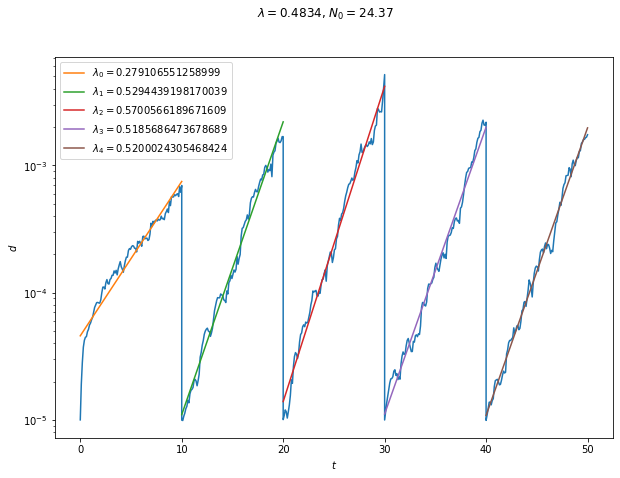

In [ ]:
g=10
cooling_phase=1.0

ranges=[]
lams=[]

generate_constants(0.01)

for i in range(0, 4):
    orig_psi = get_initial_psi()
    l = SimpleLyapunovGPE(orig_psi)
    lam, dys_range, errors = l.get_lam_mmf(pullbacks=5, T=10, rtol=1e-8, atol=1e-8)
    print('lambdas = ', lam)
    ranges.append(dys_range)
    lams.append(lam)
print(Ns)
print(ranges)
print(lams)

KeyboardInterrupt: ignored

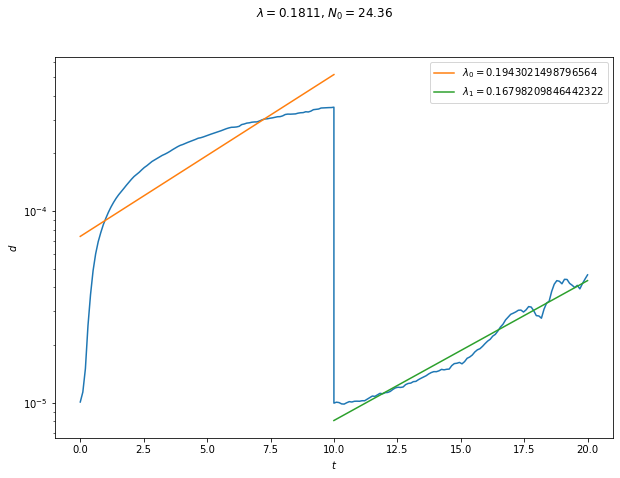

In [ ]:
g=5
cooling_phase=1.0

ranges=[]
lams=[]

generate_constants(0.01)

for i in range(0, 4):
    orig_psi = get_initial_psi()
    l = SimpleLyapunovGPE(orig_psi)
    lam, dys_range, errors = l.get_lam_mmf(pullbacks=5, T=10, rtol=1e-8, atol=1e-8)
    print('lambdas = ', lam)
    ranges.append(dys_range)
    lams.append(lam)
print(Ns)
print(ranges)
print(lams)

In [ ]:
g=15
cooling_phase=1.0

ranges=[]
lams=[]

generate_constants(0.01)

for i in range(0, 4):
    orig_psi = get_initial_psi()
    l = SimpleLyapunovGPE(orig_psi)
    lam, dys_range, errors = l.get_lam_mmf(pullbacks=5, T=10, rtol=1e-8, atol=1e-8)
    print('lambdas = ', lam)
    ranges.append(dys_range)
    lams.append(lam)
print(Ns)
print(ranges)
print(lams)

KeyboardInterrupt: ignored

lambdas =  [0.00013514944893841668, -0.00034902368065205795, 0.0003032542434079438, -9.902692204986743e-05, 0.0001038708574589353]


KeyboardInterrupt: ignored

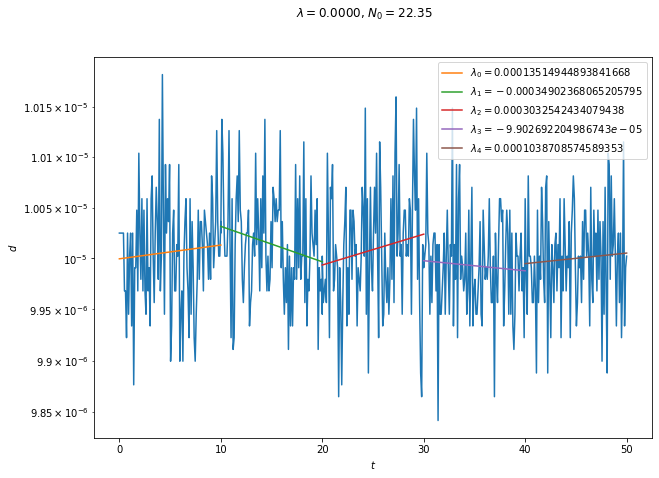

In [ ]:
g=0
cooling_phase=1.0

ranges=[]
lams=[]

generate_constants(0.01)

for i in range(0, 4):
    orig_psi = get_initial_psi()
    l = SimpleLyapunovGPE(orig_psi)
    lam, dys_range, errors = l.get_lam_mmf(pullbacks=5, T=10, rtol=1e-8, atol=1e-8)
    print('lambdas = ', lam)
    ranges.append(dys_range)
    lams.append(lam)

In [ ]:
gs = [-10.0, -8.947368421052632, -7.894736842105264, -6.842105263157895, -5.7894736842105265, -4.736842105263158, -3.6842105263157894, -2.6315789473684212, -1.578947368421053, -0.526315789473685, 0.5263157894736832, 1.5789473684210513, 2.6315789473684212, 3.6842105263157894, 4.7368421052631575, 5.789473684210526, 6.842105263157894, 7.894736842105264, 8.94736842105263, 10.0]
ranges = [35.44871031035814, 35.299824610038584, 35.8407711356405, 34.85785610706547, 35.770667569700166, 35.685379357842, 24.942086609233247, 19.118774168168063, 0.00012380934328256945, 3.6005925574462626e-05, 5.3528332871422185e-06, 0.00015424036688310827, 0.0006490904095330253, 0.0017151503624739833, 0.003898040277831676, 0.012367005050596857, 0.0265400156661378, 0.144396518495093, 0.1817335877876519, 0.3140364902088456]
lams = [[0.18500045127413342, 0.3635791732267656, 0.35852705465468754], [0.1030544827324045, 0.3092319118992893, 0.3022669608595453], [0.3232184296261938, 0.3830713569300543, 0.4961285955287264], [0.3424013272391328, 0.4468079664752209, 0.45441706512470953], [0.4126660697282967, 0.3187883221391779, 0.5482147574726014], [0.11350749459388045, 0.40054169906476444, 0.5521323296430309], [0.4541102605185765, 0.44488935258907353, 0.45530922705119786], [0.7365795281119795, 0.7601190652218173, 0.6184281105096204], [0.21657333751336175, 0.08742826293150428, 0.1082210174044841], [0.11130677037725628, 0.02843641184669688, 0.00952561469150995], [0.008967550046089933, 0.010730672697850625, 0.005850489342571076], [0.06068863915583518, 0.11348547503375489, 0.13319431965680525], [0.09305525969795576, 0.19208085597127986, 0.21516567122509583], [0.1283445758064221, 0.24045467458213018, 0.2770603426167347], [0.16353445574962946, 0.31014424937758484, 0.3216550724507886], [0.1957160953607928, 0.3869279454639839, 0.36219104609308106], [0.3487526074000372, 0.3810981542459411, 0.42449047795186734], [0.3204313159335127, 0.46005900334896915, 0.47797023372952635], [0.33120474179659576, 0.5075565878419275, 0.5167938316378038], [0.4078177790660541, 0.5683314783510799, 0.5196889679066672]]

lams[]

TypeError: ignored